<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>
</font>
<br>
<img src="https://static.tildacdn.one/tild3639-3035-4131-a461-363737393037/noroot.png" alt="University Logo" width="400" height="224">
<br>
<font face="Times New Roman" size=5 align=center>
Sharif University of Technology
<br>
Electrical Engineering Department
</font>
<br>
<font size=6>
Assignment 4: Feature Engineering
</font>
<br>
<font size=4>
Zahra Helalizadeh 400102193
<br>
</font>
<font size=4>
Spring 2025
<br>
</font>
<font face="Times New Roman" size=4>
</font>
</div></font>

# 1. Introduction

In this assignment, we explore the powerful concept of **feature engineering**, a crucial step in the data science pipeline that significantly influences the performance of machine learning models. Feature engineering involves transforming raw data into meaningful representations that make patterns more visible to algorithms.

We use the **Fashion MNIST** dataset for this assignment, which contains grayscale images of clothing items (e.g., shirts, shoes, and trousers). Each image is a 28×28 pixel matrix and is labeled with one of ten categories. While this dataset is originally designed for image classification, we will treat it as a basis to practice general feature engineering techniques, including creating custom features and applying dimensionality reduction.

Throughout this notebook, we will:

1. Visualize the dataset to gain insights.
2. Create new features using various strategies such as ratios, binning, and aggregations.
3. Simulate temporal features (despite the dataset lacking timestamps).
4. Use statistical methods like **Mutual Information** for feature selection.
5. Reduce feature space dimensionality using **Principal Component Analysis (PCA)**.
6. Reflect on when feature engineering is optional and when it becomes essential.

By the end of this notebook, we aim to better understand how engineered features can enhance the representation of data and improve model effectiveness, especially in real-world scenarios where raw data is not always sufficient.

# 2. Dataset Overview
In this section, we load and examine the Fashion MNIST dataset. This dataset is a popular benchmark in computer vision and machine learning, consisting of grayscale images of various clothing items. It contains 70,000 images in total:

* 60,000 training samples
* 10,000 test samples

Each image is 28×28 pixels in size, and each pixel has an intensity value between 0 and 255. The labels represent 10 different classes of clothing items.

## Load the Dataset

In [ ]:
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Show basic shapes
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training data shape: (60000, 28, 28)
Test data shape: (10000, 28, 28)
Training labels shape: (60000,)
Test labels shape: (10000,)


## Class Labels
Fashion MNIST has 10 categories labeled from 0 to 9. Here are the class names:

<ipython-input-2-5c413068bda3>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='Set2')


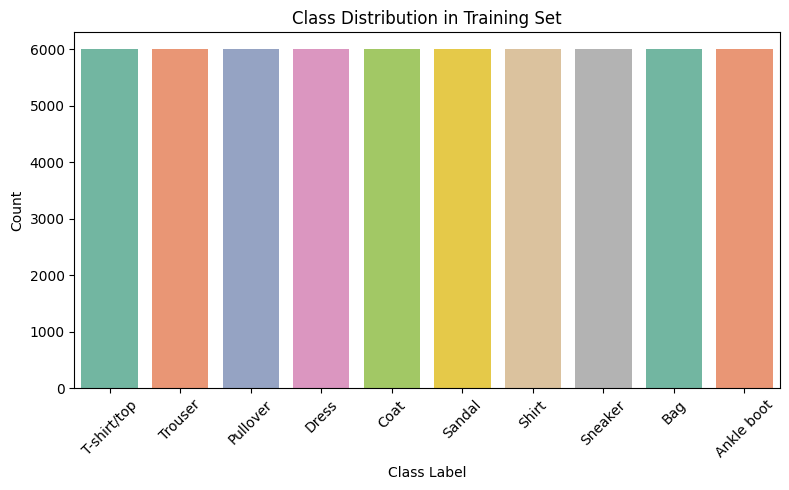

In [ ]:
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Display class distribution in training set
import pandas as pd

label_counts = pd.Series(y_train).value_counts().sort_index()
plt.figure(figsize=(8, 5))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='Set2')
plt.xticks(ticks=range(10), labels=class_names, rotation=45)
plt.title("Class Distribution in Training Set")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## Sample Images
Let’s visualize a few example images from the dataset:

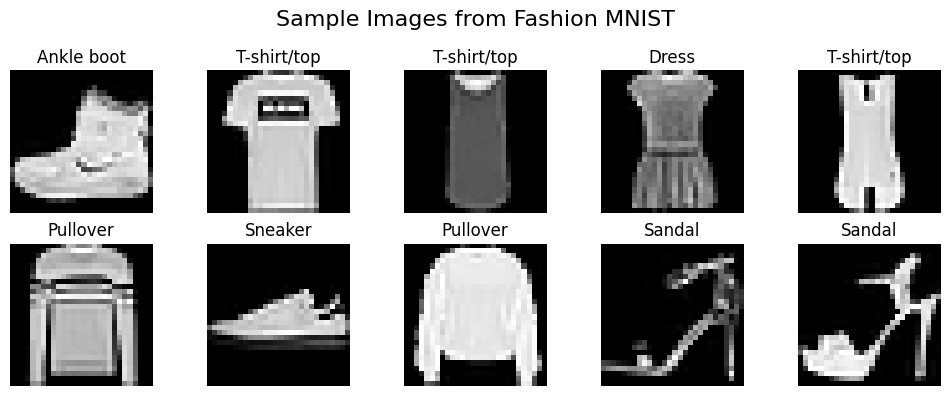

In [ ]:
# Display 10 sample images
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(class_names[y_train[i]])
    plt.axis('off')
plt.suptitle("Sample Images from Fashion MNIST", fontsize=16)
plt.tight_layout()
plt.show()

## Observations

1. The dataset is balanced, with roughly the same number of images for each class.

2. Images are relatively simple and low-resolution, which makes it a good candidate for practicing feature engineering.

3. Although raw pixel values can be used as features, better representations can improve model interpretability and accuracy — which is the goal of this assignment.

# 3. Data Visualization
Before diving into feature engineering, it’s essential to explore the dataset visually. Data visualization helps us understand the underlying patterns, distributions, and potential anomalies in the data.

In this section, we will:

1. Visualize sample images for each class

2. Explore pixel intensity distributions

3. Compare average images across classes

## 3.1 Visualizing One Sample per Class
To get a better idea of what each class looks like, let's display one sample image for each of the 10 clothing categories:

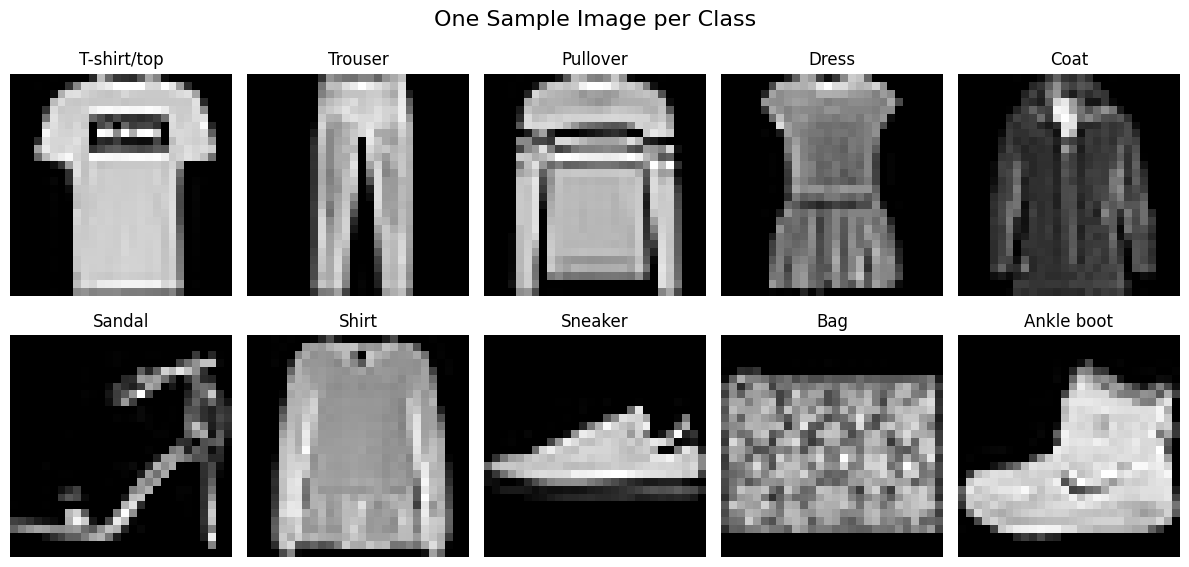

In [ ]:
plt.figure(figsize=(12, 6))

for label in range(10):
    idx = np.where(y_train == label)[0][0]  # First occurrence of each class
    plt.subplot(2, 5, label + 1)
    plt.imshow(X_train[idx], cmap='gray')
    plt.title(class_names[label])
    plt.axis('off')

plt.suptitle("One Sample Image per Class", fontsize=16)
plt.tight_layout()
plt.show()

## 3.2 Pixel Intensity Distribution
Let’s analyze the distribution of pixel intensities for a few random images. This can reveal how sparse or dense the images are and help later when applying thresholding or binning techniques.

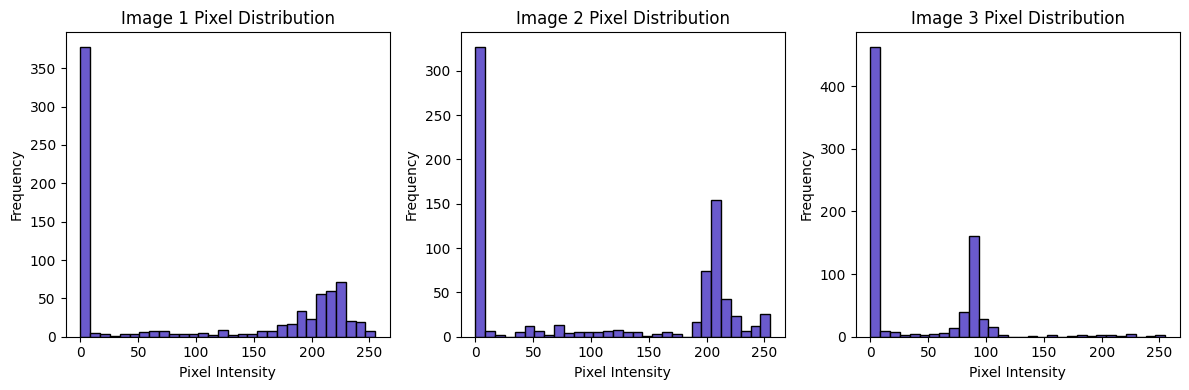

In [ ]:
plt.figure(figsize=(12, 4))

for i in range(3):
    img = X_train[i]
    plt.subplot(1, 3, i + 1)
    plt.hist(img.ravel(), bins=30, color='slateblue', edgecolor='black')
    plt.title(f"Image {i+1} Pixel Distribution")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

## 3.3 Average Image per Class
To understand the general structure of each class, we calculate and visualize the average image for every clothing category. This helps us recognize the most defining visual features.

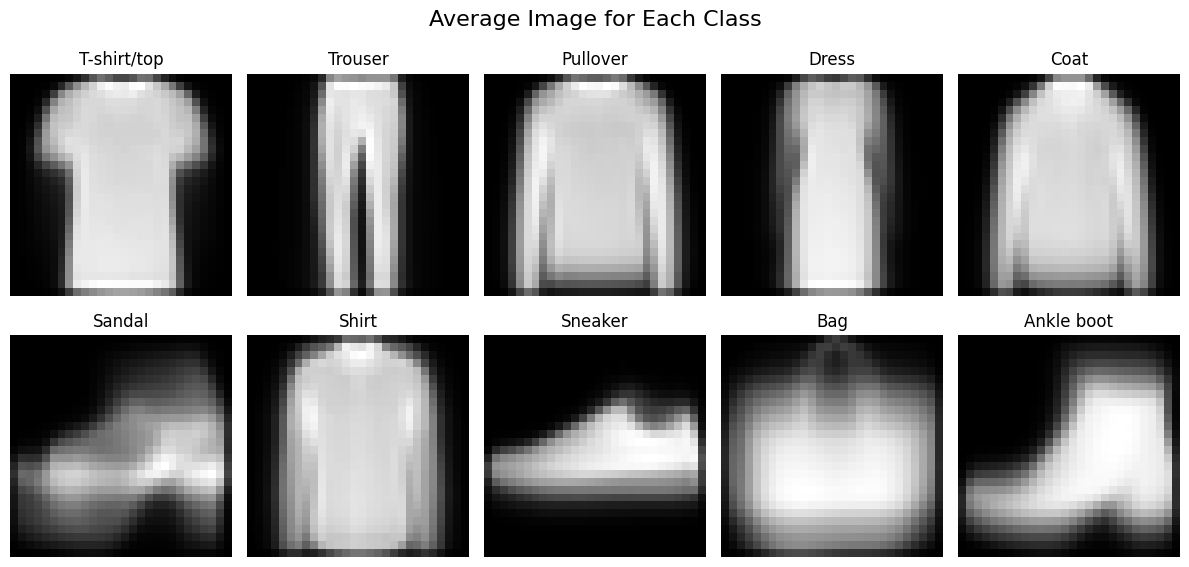

In [ ]:
plt.figure(figsize=(12, 6))

for label in range(10):
    class_images = X_train[y_train == label]
    avg_image = np.mean(class_images, axis=0)

    plt.subplot(2, 5, label + 1)
    plt.imshow(avg_image, cmap='gray')
    plt.title(class_names[label])
    plt.axis('off')

plt.suptitle("Average Image for Each Class", fontsize=16)
plt.tight_layout()
plt.show()

## Observations

1. Pixel distributions are typically centered around low intensities, since the background is black and the clothing item occupies part of the image.

2. Average images show rough outlines of each clothing type, useful for understanding key regions of interest (e.g., top vs. bottom of the image).

3. Some classes (e.g., Shirt and T-shirt/top) look visually similar — this might challenge classifiers and highlights the importance of engineered features.

# 4. Feature Engineering

Feature engineering is the process of transforming raw data into meaningful features that can improve the performance of machine learning models. Although the Fashion MNIST dataset consists of raw pixel values, we can still extract high-level, interpretable features from these images to simulate a real-world feature engineering scenario.

In this section, we will construct new features using several techniques, starting with ratios.

## 4.1 Creating New Features

We'll reshape the 28×28 pixel images into 1D arrays (for vectorized operations), and then extract meaningful features based on various techniques.

In [ ]:
# Flatten the images from 28x28 to 784 features
X_train_flat = X_train.reshape(len(X_train), -1)
X_test_flat = X_test.reshape(len(X_test), -1)

print("New shape of training data:", X_train_flat.shape)

New shape of training data: (60000, 784)


###4.1.1 Ratio Features

Ratio features are useful when comparing quantities relative to one another. In the context of image data, we can create ratios that describe spatial characteristics of the image.

Here are a few ideas:

1. Top-to-bottom pixel intensity ratio

2. Left-to-right pixel intensity ratio

3. Edge-to-center intensity ratio

These features may help a model distinguish classes with different shapes or orientations (e.g., dresses vs. trousers).

In [ ]:
def extract_ratio_features(X):
    n_samples = X.shape[0]
    X = X.reshape(n_samples, 28, 28)

    # Top-to-bottom half intensity ratio
    top_half = X[:, :14, :].sum(axis=(1, 2))
    bottom_half = X[:, 14:, :].sum(axis=(1, 2))
    top_bottom_ratio = top_half / (bottom_half + 1e-6)  # Avoid division by zero

    # Left-to-right half intensity ratio
    left_half = X[:, :, :14].sum(axis=(1, 2))
    right_half = X[:, :, 14:].sum(axis=(1, 2))
    left_right_ratio = left_half / (right_half + 1e-6)

    # Edge (border) to center intensity ratio
    edge = X[:, :4, :].sum(axis=(1, 2)) + X[:, -4:, :].sum(axis=(1, 2)) + \
           X[:, :, :4].sum(axis=(1, 2)) + X[:, :, -4:].sum(axis=(1, 2))
    center = X[:, 10:18, 10:18].sum(axis=(1, 2))
    edge_center_ratio = edge / (center + 1e-6)

    return np.stack([top_bottom_ratio, left_right_ratio, edge_center_ratio], axis=1)

# Apply the function to extract ratio features
X_train_ratio = extract_ratio_features(X_train)
X_test_ratio = extract_ratio_features(X_test)

# Display a few examples
import pandas as pd
ratio_df = pd.DataFrame(X_train_ratio, columns=["Top/Bottom", "Left/Right", "Edge/Center"])
ratio_df.head()

,Top/Bottom,Left/Right,Edge/Center
0,0.445550,0.490597,1.806723
1,1.209979,0.839607,1.822359
2,1.102553,0.832492,1.574426
3,1.130967,0.967731,2.195439
4,0.804181,1.045567,1.009056


#### Interpretation

These features give us a compact summary of where the image's intensity is concentrated.

For example, trousers likely have a higher top-to-bottom ratio since the pixel values are concentrated vertically.

These ratios may be especially helpful when using models that don't automatically extract spatial patterns (e.g., decision trees or logistic regression).

### 4.1.2 Binning

Binning (also known as discretization) is the process of converting continuous features into discrete intervals or "bins". This can simplify the feature space and help models capture non-linear patterns.

In the context of images, we can bin pixel intensities into discrete ranges — for example, to highlight low, medium, and high-intensity regions.

We will:

1. Create 3 bins: low (0–85), medium (86–170), and high (171–255)

2. Count the number of pixels falling into each bin for every image

#### Applying Intensity Binning

In [ ]:
def bin_pixel_intensities(X):
    X_flat = X.reshape(X.shape[0], -1)
    low_bin = np.sum((X_flat >= 0) & (X_flat <= 85), axis=1)
    medium_bin = np.sum((X_flat > 85) & (X_flat <= 170), axis=1)
    high_bin = np.sum((X_flat > 170), axis=1)

    return np.stack([low_bin, medium_bin, high_bin], axis=1)

# Apply to training and test sets
X_train_binned = bin_pixel_intensities(X_train)
X_test_binned = bin_pixel_intensities(X_test)

# Display first few rows
binning_df = pd.DataFrame(X_train_binned, columns=["Low Intensity", "Medium Intensity", "High Intensity"])
binning_df.head()

,Low Intensity,Medium Intensity,High Intensity
0,419,46,319
1,377,48,359
2,584,182,18
3,460,295,29
4,506,22,256


#### Visualizing Pixel Intensity Bins

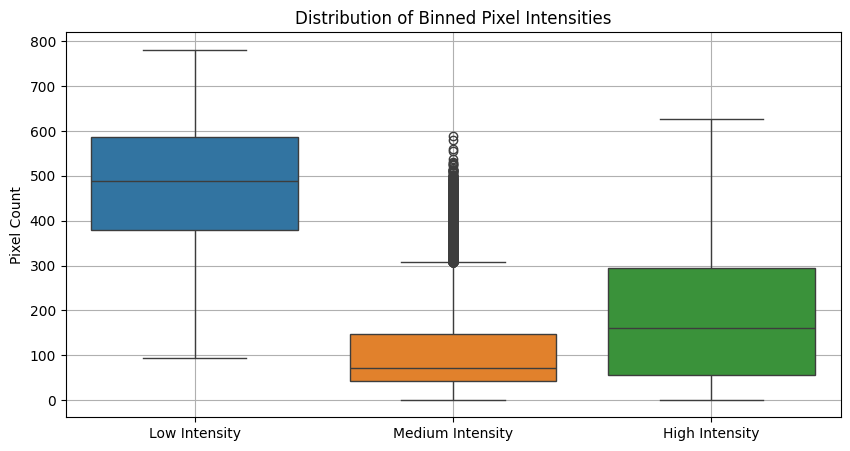

In [ ]:
import seaborn as sns

# Plot distribution of binned pixel counts
plt.figure(figsize=(10, 5))
sns.boxplot(data=binning_df)
plt.title("Distribution of Binned Pixel Intensities")
plt.ylabel("Pixel Count")
plt.grid(True)
plt.show()

#### Why Binning Helps

1. Reduces noise in raw pixel values by grouping similar intensities

2. Simplifies the feature space, making it easier for models like decision trees or Naive Bayes to find patterns

3. Makes features interpretable: "How many bright pixels does this image have?"

### 4.1.3 Functions of a Column

In feature engineering, applying mathematical or statistical functions to a single feature (or column) can help capture additional patterns. These derived features often provide the model with richer information than the raw features alone.

Since our dataset consists of flattened pixel intensity values, we can apply various functions to each image's pixel vector to extract meaningful summaries.

#### Feature Ideas

For each image (flattened to 784 pixels), we'll compute:

1. Mean intensity – average brightness

2. Standard deviation – contrast or variation

3. Skewness – asymmetry of pixel distribution

4. Kurtosis – sharpness of the intensity peak

#### Applying Functions

In [ ]:
from scipy.stats import skew, kurtosis

def pixel_stats(X):
    X_flat = X.reshape(X.shape[0], -1)

    means = np.mean(X_flat, axis=1)
    stds = np.std(X_flat, axis=1)
    skews = skew(X_flat, axis=1)
    kurtoses = kurtosis(X_flat, axis=1)

    return np.stack([means, stds, skews, kurtoses], axis=1)

# Apply to train and test sets
X_train_func = pixel_stats(X_train)
X_test_func = pixel_stats(X_test)

# Create a DataFrame for inspection
func_df = pd.DataFrame(X_train_func, columns=["Mean", "Std", "Skewness", "Kurtosis"])
func_df.head()

,Mean,Std,Skewness,Kurtosis
0,97.253827,101.792346,0.219186,-1.816807
1,107.905612,100.831448,0.013599,-1.849794
2,36.558673,49.698752,1.253612,1.568225
3,59.501276,64.849295,0.439461,-1.307167
4,78.044643,103.843248,0.653719,-1.488643


#### Visualizing Function-Based Features

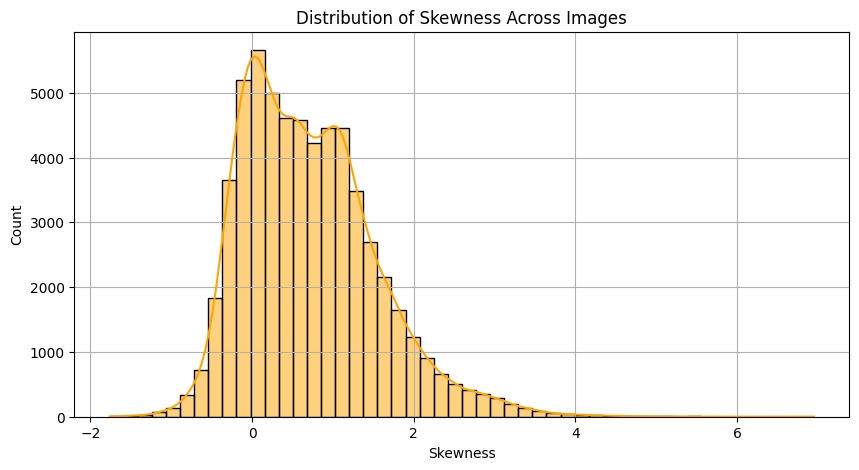

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(func_df["Skewness"], kde=True, bins=50, color='orange')
plt.title("Distribution of Skewness Across Images")
plt.xlabel("Skewness")
plt.grid(True)
plt.show()

#### Why These Features Matter

1. Mean & Std: Capture the overall brightness and contrast of the image

2. Skewness: Helps identify whether the image is darker or lighter on average

3. Kurtosis: Highlights whether the image has a sharp center (e.g., small object) or spread-out intensity (e.g., larger item)

These are helpful especially for non-deep learning models, which don't automatically extract such summaries.

### 4.1.4 Combining Columns
Sometimes, creating new features by combining existing columns can capture interactions between different attributes that individual features alone cannot reveal. This is especially useful when relationships between features are non-linear or multiplicative.

In the case of image data, we can combine the features we've engineered so far — such as ratio features, binned intensity counts, and function-based features — to create more expressive features.

#### Example: Combining Features

We'll demonstrate this by:

1. Calculating the product of the Top/Bottom intensity ratio and the Mean pixel intensity

2. Creating a new feature as the sum of Medium Intensity pixels and Standard Deviation

3. Calculating the ratio of High Intensity pixels to Edge/Center ratio

In [ ]:
# Combine previously computed features for the training set
combined_features_train = pd.DataFrame({
    "Top_Bottom_Ratio": X_train_ratio[:, 0],
    "Left_Right_Ratio": X_train_ratio[:, 1],
    "Edge_Center_Ratio": X_train_ratio[:, 2],
    "Low_Intensity": X_train_binned[:, 0],
    "Medium_Intensity": X_train_binned[:, 1],
    "High_Intensity": X_train_binned[:, 2],
    "Mean_Intensity": X_train_func[:, 0],
    "Std_Intensity": X_train_func[:, 1],
    "Skewness": X_train_func[:, 2],
    "Kurtosis": X_train_func[:, 3],
})

# New combined features
combined_features_train["TopBottom_Mean_Product"] = combined_features_train["Top_Bottom_Ratio"] * combined_features_train["Mean_Intensity"]
combined_features_train["MediumPlusStd"] = combined_features_train["Medium_Intensity"] + combined_features_train["Std_Intensity"]
combined_features_train["HighIntensity_EdgeCenter_Ratio"] = combined_features_train["High_Intensity"] / (combined_features_train["Edge_Center_Ratio"] + 1e-6)

combined_features_train.head()

,Top_Bottom_Ratio,Left_Right_Ratio,Edge_Center_Ratio,Low_Intensity,Medium_Intensity,High_Intensity,Mean_Intensity,Std_Intensity,Skewness,Kurtosis,TopBottom_Mean_Product,MediumPlusStd,HighIntensity_EdgeCenter_Ratio
0,0.445550,0.490597,1.806723,419,46,319,97.253827,101.792346,0.219186,-1.816807,43.331479,147.792346,176.562618
1,1.209979,0.839607,1.822359,377,48,359,107.905612,100.831448,0.013599,-1.849794,130.563536,148.831448,196.997285
2,1.102553,0.832492,1.574426,584,182,18,36.558673,49.698752,1.253612,1.568225,40.307868,231.698752,11.432730
3,1.130967,0.967731,2.195439,460,295,29,59.501276,64.849295,0.439461,-1.307167,67.293983,359.849295,13.209196
4,0.804181,1.045567,1.009056,506,22,256,78.044643,103.843248,0.653719,-1.488643,62.762032,125.843248,253.702218


#### Interpretation

1. TopBottom_Mean_Product captures how the vertical intensity distribution interacts with overall brightness.

2. MediumPlusStd combines the count of medium brightness pixels with contrast, which might help differentiate texture.

3. HighIntensity_EdgeCenter_Ratio reflects how bright pixels near edges relate to the central region, potentially useful for distinguishing items with distinct edges.

## 4.2 Date/Time Features

Date and time features often provide valuable context in many datasets, especially those involving timestamps such as logs, transactions, or sensor data. Extracting features like day of week, month, hour, or elapsed time can reveal important temporal patterns.

### Note on Fashion MNIST

The Fashion MNIST dataset does not contain explicit date or time information because it consists of images labeled by category.

To practice date/time feature engineering, we will simulate a timestamp feature by assigning a random "acquisition date" to each sample. This will allow us to demonstrate common techniques for extracting date/time-based features.

### Simulating Date/Time Data

In [ ]:
import pandas as pd
import numpy as np

# Generate random dates within a year for each training sample
np.random.seed(42)
date_range = pd.date_range(start='2023-01-01', end='2023-12-31')
random_dates = np.random.choice(date_range, size=len(X_train))

# Create a DataFrame to store dates
dates_df = pd.DataFrame({"acquisition_date": random_dates})

# Show first few dates
dates_df.head()

,acquisition_date
0,2023-04-13
1,2023-12-15
2,2023-09-28
3,2023-04-17
4,2023-03-13


## Extracting Date/Time Features

We'll extract useful features such as:

1. Day of week (Monday=0, Sunday=6)

2. Month of the year

3. Is weekend (Boolean)

4. Day of year

5. Elapsed days since start of dataset

In [ ]:
dates_df["day_of_week"] = dates_df["acquisition_date"].dt.dayofweek
dates_df["month"] = dates_df["acquisition_date"].dt.month
dates_df["is_weekend"] = dates_df["day_of_week"].isin([5,6]).astype(int)
dates_df["day_of_year"] = dates_df["acquisition_date"].dt.dayofyear
dates_df["elapsed_days"] = (dates_df["acquisition_date"] - dates_df["acquisition_date"].min()).dt.days

dates_df.head()

,acquisition_date,day_of_week,month,is_weekend,day_of_year,elapsed_days
0,2023-04-13,3,4,0,103,102
1,2023-12-15,4,12,0,349,348
2,2023-09-28,3,9,0,271,270
3,2023-04-17,0,4,0,107,106
4,2023-03-13,0,3,0,72,71


### Visualizing Date/Time Features

<ipython-input-16-673e2d7bc248>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="month", data=dates_df, palette="viridis")


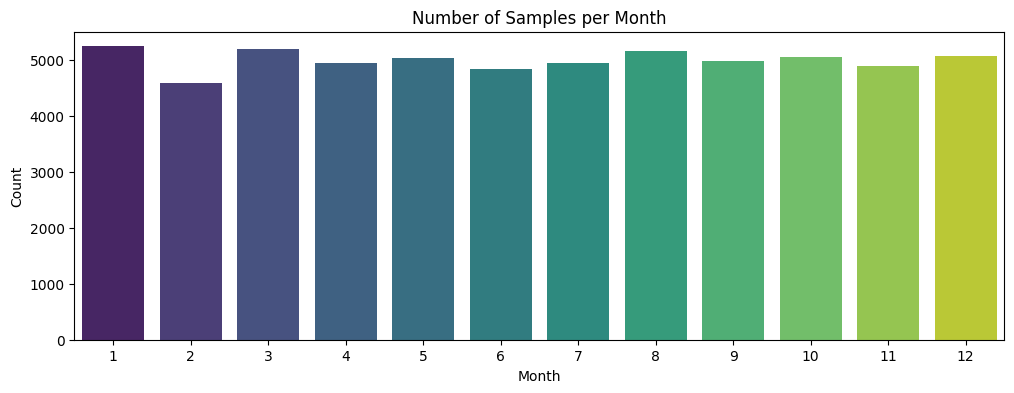

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 4))
sns.countplot(x="month", data=dates_df, palette="viridis")
plt.title("Number of Samples per Month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.show()

### Importance of Date/Time Features

1. Capture seasonal patterns or trends over time

2. Help models account for temporal dependencies or periodicity

3. Useful in domains such as retail, finance, healthcare, and sensor analytics

## 4.3 Counts and Aggregation

Counting occurrences and aggregating values are common feature engineering techniques that help summarize data, especially categorical or grouped data. Aggregation can reveal patterns within subsets of the data, improving the model’s ability to generalize.

### Note on Fashion MNIST

Since Fashion MNIST consists of images labeled by categories, we can use counts and aggregation based on the class labels to extract useful features such as:

1. The number of images per class

2. Average pixel intensities aggregated by class

3. Aggregated statistics of features we created earlier

### Counting Samples Per Class

In [ ]:
import pandas as pd

# Count number of samples for each class in the training set
class_counts = pd.Series(y_train).value_counts().sort_index()
class_counts_df = pd.DataFrame({"Class": class_counts.index, "Count": class_counts.values})

class_counts_df

,Class,Count
0,0,6000
1,1,6000
2,2,6000
3,3,6000
4,4,6000
5,5,6000
6,6,6000
7,7,6000
8,8,6000
9,9,6000


### Aggregating Features by Class

Let's calculate the average pixel intensity and average of our engineered features grouped by class.

In [ ]:
# Flatten images and compute mean intensity for each image
X_train_flat = X_train.reshape(X_train.shape[0], -1)
mean_intensity_per_image = np.mean(X_train_flat, axis=1)

# Create DataFrame combining mean intensity and labels
df_agg = pd.DataFrame({
    "label": y_train,
    "mean_intensity": mean_intensity_per_image,
    "top_bottom_ratio": X_train_ratio[:, 0],  # assuming previously calculated
    "medium_intensity": X_train_binned[:, 1],  # assuming previously calculated
    "mean_function": X_train_func[:, 0],  # assuming previously calculated mean pixel intensity
})

# Group by class label and aggregate
agg_stats = df_agg.groupby("label").agg({
    "mean_intensity": "mean",
    "top_bottom_ratio": "mean",
    "medium_intensity": "mean",
    "mean_function": "mean",
    "label": "count"
}).rename(columns={"label": "count"})

agg_stats

,mean_intensity,top_bottom_ratio,medium_intensity,mean_function,count
label,,,,,
0,83.029980,1.233244,140.885000,83.029980,6000
1,56.840855,1.358007,79.585500,56.840855,6000
2,96.058763,0.978372,154.916833,96.058763,6000
3,66.018909,0.900426,94.461333,66.018909,6000
4,98.258006,0.911359,119.786333,98.258006,6000
5,34.867547,0.502132,78.409167,34.867547,6000
6,84.605120,0.973415,161.683333,84.605120,6000
7,42.762072,0.546551,71.463000,42.762072,6000
8,90.157153,0.602060,127.794500,90.157153,6000


### Visualizing Aggregations

<ipython-input-19-5a32701ec07f>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=agg_stats.index, y=agg_stats["mean_intensity"], palette="coolwarm")


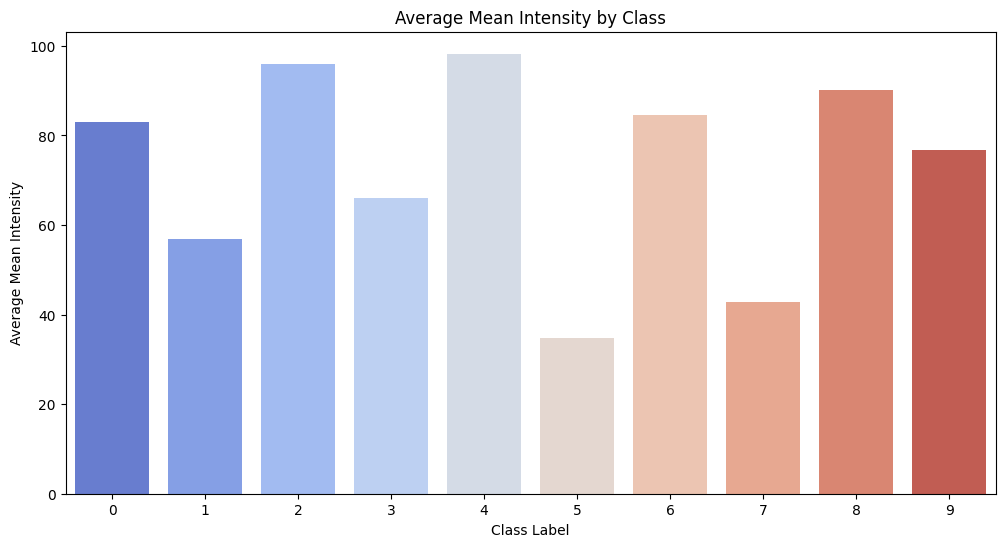

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x=agg_stats.index, y=agg_stats["mean_intensity"], palette="coolwarm")
plt.title("Average Mean Intensity by Class")
plt.xlabel("Class Label")
plt.ylabel("Average Mean Intensity")
plt.show()

### Why Counts and Aggregations Matter

1. Provide summary statistics that can distinguish classes

2. Help models capture group-level patterns

3. Reduce noise by averaging over samples within the same category

# 5. Feature Selection

Feature selection is an important step to improve model performance by removing irrelevant or redundant features. It helps in reducing overfitting, improving accuracy, and decreasing training time.

## 5.1 Mutual Information

Mutual Information (MI) measures the dependency between two variables. In feature selection, MI quantifies how much knowing a feature reduces uncertainty about the target variable. Features with higher mutual information scores are generally more informative for prediction.

### Calculating Mutual Information for Our Features

We'll calculate mutual information between our engineered features and the target labels (y_train) to identify the most relevant features.

In [ ]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

# Combine all engineered features into one DataFrame for selection
features_df = pd.DataFrame({
    "Top_Bottom_Ratio": X_train_ratio[:, 0],
    "Left_Right_Ratio": X_train_ratio[:, 1],
    "Edge_Center_Ratio": X_train_ratio[:, 2],
    "Low_Intensity": X_train_binned[:, 0],
    "Medium_Intensity": X_train_binned[:, 1],
    "High_Intensity": X_train_binned[:, 2],
    "Mean_Intensity": X_train_func[:, 0],
    "Std_Intensity": X_train_func[:, 1],
    "Skewness": X_train_func[:, 2],
    "Kurtosis": X_train_func[:, 3],
    "TopBottom_Mean_Product": combined_features_train["TopBottom_Mean_Product"],
    "MediumPlusStd": combined_features_train["MediumPlusStd"],
    "HighIntensity_EdgeCenter_Ratio": combined_features_train["HighIntensity_EdgeCenter_Ratio"],
    # Add date/time features if applicable, e.g.:
    # "Day_of_Week": dates_df["day_of_week"],
    # "Month": dates_df["month"],
}, index=None)

# Calculate mutual information scores
mi_scores = mutual_info_classif(features_df, y_train, discrete_features=False, random_state=42)

# Create a DataFrame of feature names and their MI scores
mi_df = pd.DataFrame({"Feature": features_df.columns, "Mutual Information": mi_scores})
mi_df = mi_df.sort_values(by="Mutual Information", ascending=False).reset_index(drop=True)

mi_df

,Feature,Mutual Information
0,Top_Bottom_Ratio,0.607375
1,Left_Right_Ratio,0.549112
2,Low_Intensity,0.502289
3,Skewness,0.473386
4,TopBottom_Mean_Product,0.466773
5,Mean_Intensity,0.366792
6,Edge_Center_Ratio,0.357675
7,Kurtosis,0.319347
8,High_Intensity,0.294950
9,HighIntensity_EdgeCenter_Ratio,0.188760


### Visualizing Mutual Information Scores

<ipython-input-21-abee0385e649>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Mutual Information", y="Feature", data=mi_df, palette="magma")


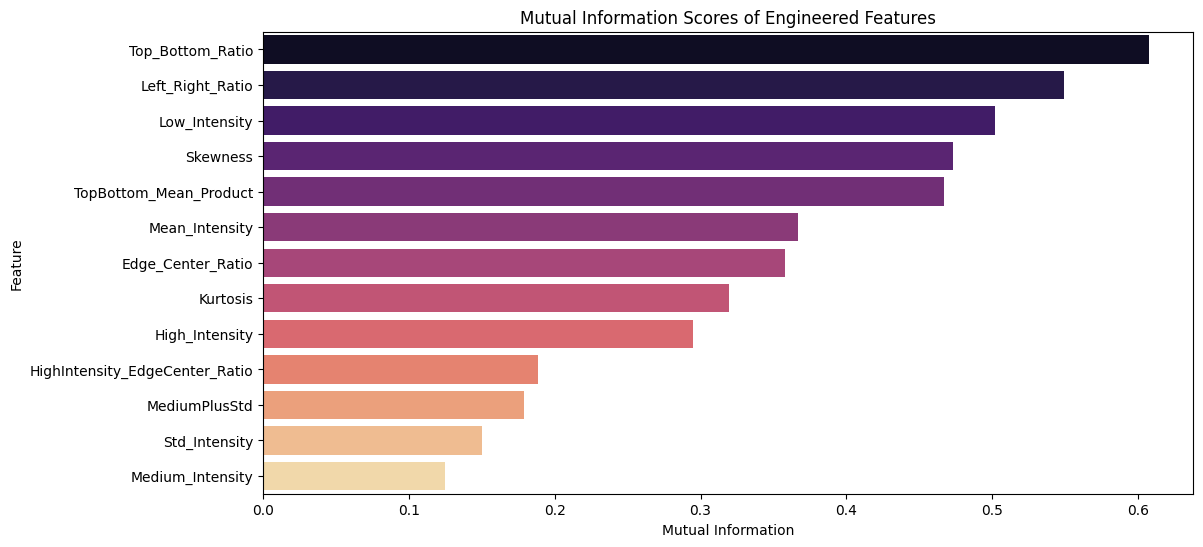

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x="Mutual Information", y="Feature", data=mi_df, palette="magma")
plt.title("Mutual Information Scores of Engineered Features")
plt.xlabel("Mutual Information")
plt.ylabel("Feature")
plt.show()

### Interpretation

1. Features with higher mutual information scores are more informative for predicting clothing categories.

2. This helps in selecting a subset of features to reduce dimensionality while retaining predictive power.

3. Mutual information captures non-linear relationships unlike simple correlation.

# 6. Dimensionality Reduction

High-dimensional data can be challenging for many machine learning algorithms due to the "curse of dimensionality," increased computational cost, and risk of overfitting. Dimensionality reduction techniques help simplify the data while preserving its important structures and patterns.

## 6.1 Principal Component Analysis (PCA)

Principal Component Analysis (PCA) is a widely used technique that transforms the original features into a new set of uncorrelated variables called principal components. These components capture the maximum variance in the data in descending order.

### Applying PCA to Our Dataset

We'll apply PCA on the flattened images and on our engineered features to reduce dimensionality and visualize the most important components.

In [22]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Flatten the training images for PCA
X_train_flat = X_train.reshape(X_train.shape[0], -1)

# Normalize the data (PCA benefits from zero-centered data)
X_train_flat_centered = X_train_flat - np.mean(X_train_flat, axis=0)

# Apply PCA to retain 95% of variance
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_flat_centered)

print(f"Original number of features: {X_train_flat.shape[1]}")
print(f"Reduced number of features after PCA: {X_train_pca.shape[1]}")

Original number of features: 784
Reduced number of features after PCA: 187


### Explained Variance Ratio

Let's visualize how much variance each principal component explains.

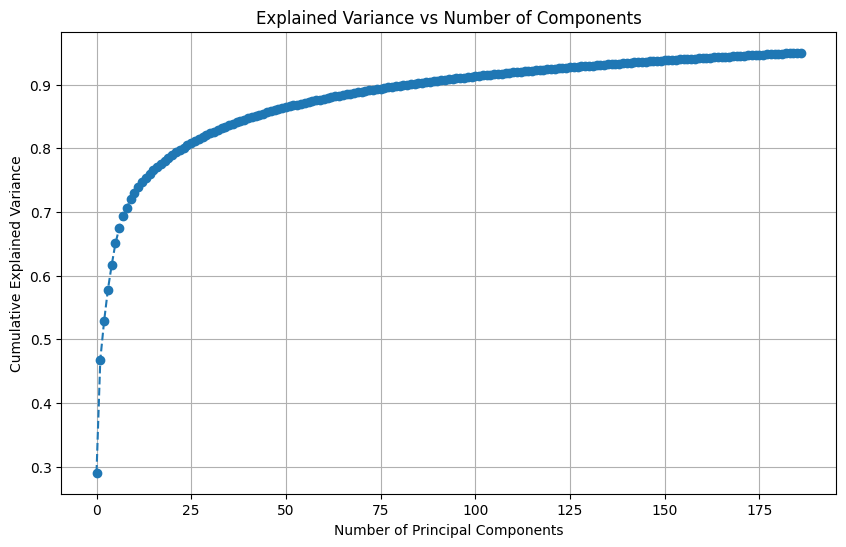

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of Components')
plt.grid(True)
plt.show()

### PCA on Engineered Features

We can also apply PCA on the engineered features to reduce feature space before model training.

In [24]:
from sklearn.preprocessing import StandardScaler

# Scale engineered features before PCA
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_df)

pca_feat = PCA(n_components=0.95, random_state=42)
features_pca = pca_feat.fit_transform(features_scaled)

print(f"Original engineered features: {features_df.shape[1]}")
print(f"Reduced features after PCA: {features_pca.shape[1]}")

Original engineered features: 13
Reduced features after PCA: 6


### Benefits of PCA

1. Reduces dimensionality while preserving most of the data variance

2. Helps to remove noise and redundant features

3. Improves computational efficiency and sometimes model performance

4. Useful for visualization in 2D or 3D space (first 2 or 3 components)

# 7. Discussion: Importance of Feature Engineering

Feature engineering is a crucial step in the data science pipeline that involves creating, transforming, and selecting variables to improve the performance and interpretability of machine learning models.

## When is Feature Engineering a *“Nice to Have”*?

1. When working with **complex models** like deep learning neural networks that automatically learn feature representations from raw data, manual feature engineering might be less critical.
2. When you have **very large datasets** where models can learn patterns directly without requiring handcrafted features.
3. When time or resources are limited and a quick baseline model is needed.
4. When the dataset already contains well-prepared and highly informative features.

## When is Feature Engineering a *“Must to Have”*?

1. When working with **traditional machine learning models** (e.g., linear regression, decision trees, SVMs) that rely heavily on quality input features.
2. When the dataset contains **raw or unstructured data** (e.g., images, text, sensor data) that need to be converted into meaningful numerical features.
3. When the dataset is **small or imbalanced**, and engineered features can improve signal-to-noise ratio.
4. When **domain knowledge** can be leveraged to create features that capture important relationships or patterns.
5. When interpretability and explainability of the model are important, as engineered features often correspond to understandable concepts.

## Summary

Feature engineering bridges the gap between raw data and effective models by:

1. Enhancing signal and reducing noise in the data
2. Improving model accuracy and robustness
3. Enabling simpler models to perform competitively
4. Providing better insights and explainability

## Personal Reflection

In this assignment, by applying various feature engineering techniques like ratio features, binning, function transformations, and aggregation, we demonstrated how raw image data can be enriched with additional meaningful information. This process ultimately aids in building more accurate and interpretable models for Fashion MNIST classification.

# 8. Conclusion

In this assignment, we explored various feature engineering techniques applied to the Fashion MNIST dataset. Starting from basic data visualization, we created new features through ratios, binning, and mathematical functions, and combined columns to enrich our dataset. We also examined ways to extract meaningful information through counts and aggregation.

Using feature selection based on mutual information, we identified the most relevant features for predicting clothing categories, helping reduce dimensionality while maintaining predictive power. Additionally, we applied Principal Component Analysis (PCA) to further reduce feature space, improving computational efficiency and highlighting the underlying structure of the data.

Overall, this exercise emphasized the critical role of feature engineering in building effective machine learning models. Thoughtful feature creation and selection not only improve model accuracy but also enhance interpretability and robustness, especially in traditional ML workflows.